In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
import shap
import xgboost

/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

## Data sets

In [4]:
adult = pd.read_csv("../datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
print("Adult Shape:", adult.shape)
adult.head(5)

Adult Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [5]:
adult_small = adult.sample(1000)
print(adult_small.shape)

(1000, 15)


In [5]:
dataset = adult
#y = y.replace(["yes","no"],[1,0])
#X = pd.get_dummies(X)
oe = OrdinalEncoder()
data = oe.fit_transform(dataset)
encoded = pd.DataFrame(data = data, columns = dataset.columns)
X = encoded.loc[:,'age':'native-country']
y = encoded.loc[:,'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
xgb_model = xgboost.XGBClassifier().fit(X_train, y_train)

y_pred = dt_model.predict(X_test)  
print("Decision Tree")
print(classification_report(y_test,y_pred))
y_pred = xgb_model.predict(X_test)  
print("XGBoost")
print(classification_report(y_test,y_pred))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      2455
         1.0       0.76      0.55      0.64       802

    accuracy                           0.85      3257
   macro avg       0.81      0.75      0.77      3257
weighted avg       0.84      0.85      0.84      3257

XGBoost
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      2455
         1.0       0.77      0.68      0.72       802

    accuracy                           0.87      3257
   macro avg       0.83      0.81      0.82      3257
weighted avg       0.87      0.87      0.87      3257



### Shapley Values

Suppose thay we have three players: A, B, and C. They will play a cooperative game and will obtain a certain gain. Players' individual contribution might be different. We want to calculate the marginal conributions of each player in order to distribute the gain according to their marginal contributions. How can we do it?

The basic idea is to find the marginal contribution of a player, say A, according to the gains in games where A is present and where A is not.



Shapley value:

$$
\phi_i(v) = \sum_{\substack{S \subseteq N \backslash \{i\} }} \frac{(n - |S| - 1)! \cdot (|S|)!}{n!} \left( v(S \cup \{i\}) - v(S) \right) 
$$

where:
- $ \phi_i(v) $ represents the Shapley value of player \( i \) in the game \( v \),
- $ N $ is the set of all players,
- $ S $ is a coalition of players,
- $ n $ is the total number of players, and
- $ v(S) $ denotes the worth of coalition $S$.



In [5]:
import math
import itertools

def calculate_shapley_value(player, player_list, characteristic_function):
    n = len(player_list)
    shapley_value = 0

    for permutation in itertools.permutations(player_list):
        print("Order:", permutation)
        coalition = []
        coalition_value = 0

        for p in permutation:
            if p == player:
                break
            else:
                coalition.append(p)
                
        coalition_value = characteristic_function(coalition)
        coalition.append(player)
        coalition_value_with_player = characteristic_function(coalition)

        marginal_contribution = coalition_value_with_player - coalition_value
        print("Marginal contribution of ", player, ": ",marginal_contribution)
        shapley_value += marginal_contribution / math.factorial(n)

    return shapley_value

# Example characteristic function
def characteristic_function(coalition):
    # Define the characteristic function here
    if len(coalition) == 0:
        return 0
    elif len(coalition) == 1:
        player = coalition[0]
        if player == 'A':
            return 100
        elif player == 'B':
            return 125
        elif player == 'C':
            return 50
    elif len(coalition) == 2:
        if 'A' in coalition and 'B' in coalition:
            return 270
        elif 'A' in coalition and 'C' in coalition:
            return 375
        elif 'B' in coalition and 'C' in coalition:
            return 350
    elif len(coalition) == 3:
        return 500

# Player list
player_list = ['A', 'B', 'C']

# Calculate Shapley values for each player
shapley_values = {}
for player in player_list:
    shapley_values[player] = calculate_shapley_value(player, player_list, characteristic_function)

# Print the Shapley values
for player, value in shapley_values.items():
    print(f"The Shapley value for player {player} is: {value}")


Order: ('A', 'B', 'C')
Marginal contribution of  A :  100
Order: ('A', 'C', 'B')
Marginal contribution of  A :  100
Order: ('B', 'A', 'C')
Marginal contribution of  A :  145
Order: ('B', 'C', 'A')
Marginal contribution of  A :  150
Order: ('C', 'A', 'B')
Marginal contribution of  A :  325
Order: ('C', 'B', 'A')
Marginal contribution of  A :  150
Order: ('A', 'B', 'C')
Marginal contribution of  B :  170
Order: ('A', 'C', 'B')
Marginal contribution of  B :  125
Order: ('B', 'A', 'C')
Marginal contribution of  B :  125
Order: ('B', 'C', 'A')
Marginal contribution of  B :  125
Order: ('C', 'A', 'B')
Marginal contribution of  B :  125
Order: ('C', 'B', 'A')
Marginal contribution of  B :  300
Order: ('A', 'B', 'C')
Marginal contribution of  C :  230
Order: ('A', 'C', 'B')
Marginal contribution of  C :  275
Order: ('B', 'A', 'C')
Marginal contribution of  C :  230
Order: ('B', 'C', 'A')
Marginal contribution of  C :  225
Order: ('C', 'A', 'B')
Marginal contribution of  C :  50
Order: ('C', 'B

### Shapley value calculation from scratch with sampling

The following code makes a local explanation. The algorithm is as follows:

To calculate the Shapley value for the feature $f_j$ in the prediction for instance $i$:

- for m = 1 to M do:
    - Sample a random subset of features $S_f$ such that $f_j \not\in S_f$.
    - Calculate the marginal contribution of $f_j$ by finding the difference between the prediction with features $S_f + f_j$ and features $S_f$.
    
The average marginal contribution will give the shapely value. This is not exact calculation but will approximate it. One problem is how to make a prediction with only a subset of the features since the model is built with all the features. Building different models for all feature subsets is infeasible. One solution is to use values for the missing features from a randomly choosen instance. The idea is when we do this many times the overall effect of the randomly chosen values will cancel out and in the long run the contribution of $f_j$ for the instance $x$ will emerge.



In [6]:
def shapley_value_by_sampling(model, X, instance_idx, feature_idx, n_iters = 1000):
    
    marginal_contributions = []

    n_features = X.shape[1]
    feature_idxs = list(range(n_features))
    x = X.iloc[instance_idx]
    feature_idxs.remove(feature_idx)

    for _ in range(n_iters):
        r = X.sample(1).values[0]

        # sample S_f
        S_f = random.sample(feature_idxs, random.randint(0,n_features-1))

        x_with_feature = np.array([x[i] if i in S_f + [feature_idx] else r[i] for i in range(n_features)]).reshape(1, -1)
        x_with_feature = pd.DataFrame(x_with_feature, columns=X.columns)
        x_without_feature = np.array([x[i] if i in S_f else r[i] for i in range(n_features)]).reshape(1, -1)
        x_without_feature = pd.DataFrame(x_without_feature, columns=X.columns)

        
        marginal_contribution = model.predict_proba(x_with_feature)[0][1] - model.predict_proba(x_without_feature)[0][1]
        marginal_contributions.append(marginal_contribution)
        
    shapley_value = sum(marginal_contributions) / len(marginal_contributions)  
    return X.columns[feature_idx], shapley_value


In [8]:
shapley_value_by_sampling(dt_model, X, 10, 7)

('relationship', 0.15671769377152625)

In [9]:
shapley_value_by_sampling(xgb_model, X, 10, 7)

('relationship', 0.1312235167148101)

### Shapely values using the shap package

In [13]:
#xgb_model = xgboost.XGBClassifier().fit(X, y)
gb_model = GradientBoostingClassifier().fit(X,y)

explainer = shap.Explainer(gb_model, X)
shap_values = explainer(X)


 99%|===================| 32367/32561 [00:31<00:00]        

The object shap_values is an instance of the explanation class. It contains, among other things, a shapley value for each instance-feature pair. The shapley value at $x_{ij}$ is the marginal contribution of feature $j$ in the prediction for the sample $i$. We can display these values as follows:

In [15]:
print(shap_values.values.shape)
pd.DataFrame(shap_values.values, columns=X.columns)

(32561, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.447975,-0.123568,-0.075010,-0.000755,0.591183,-0.206413,0.043705,-0.750913,0.007691,0.145156,-0.202517,-0.117124,-0.006885,0.001463
1,0.481523,-0.184521,-0.076706,-0.000755,0.736496,0.165881,0.385263,0.764337,0.007691,0.133528,-0.126954,-0.116767,-0.835305,0.000995
2,0.390353,0.005391,0.022181,-0.000755,-0.201143,0.087043,-0.390993,-0.668962,0.013621,0.138577,-0.177114,-0.110392,0.001917,0.005673
3,0.500954,0.005684,0.018499,-0.000755,-0.934935,0.117720,-0.392945,0.738741,-0.054863,0.149791,-0.158716,-0.109203,0.012349,0.005673
4,-0.202519,0.003946,0.015684,-0.001182,0.636445,0.206152,0.204291,1.493814,-0.102767,-0.120050,-0.151592,-0.102253,-0.058429,-0.133685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.480181,0.002259,0.026274,-0.001182,0.163634,0.181694,0.190058,1.570799,0.015448,-0.123901,-0.163985,-0.106695,-0.076269,0.010529
32557,0.404474,0.011761,0.022181,-0.000755,-0.279118,0.161325,-0.391107,0.809325,0.013621,0.138577,-0.150329,-0.110761,0.032283,0.005673
32558,0.528369,0.007646,0.015729,-0.000755,-0.212624,-0.096530,0.023605,-0.762455,0.010888,-0.337326,-0.179317,-0.109896,-0.011341,0.004524
32559,-0.860868,-0.003066,0.010529,-0.000755,-0.195094,-0.193524,0.035184,-0.770583,0.006653,0.104383,-0.186935,-0.126298,-0.558579,0.002885


### Visualizations

Using this table of values we can plot different figures.

### Global Bar Plot

Each feature's global importance is calculated as the mean of the absolute shap values of that feature over all samples. An example calculation is given below.

**Question:** Why is mean of the absolute values used but not just the mean value?

0.4865661819652103


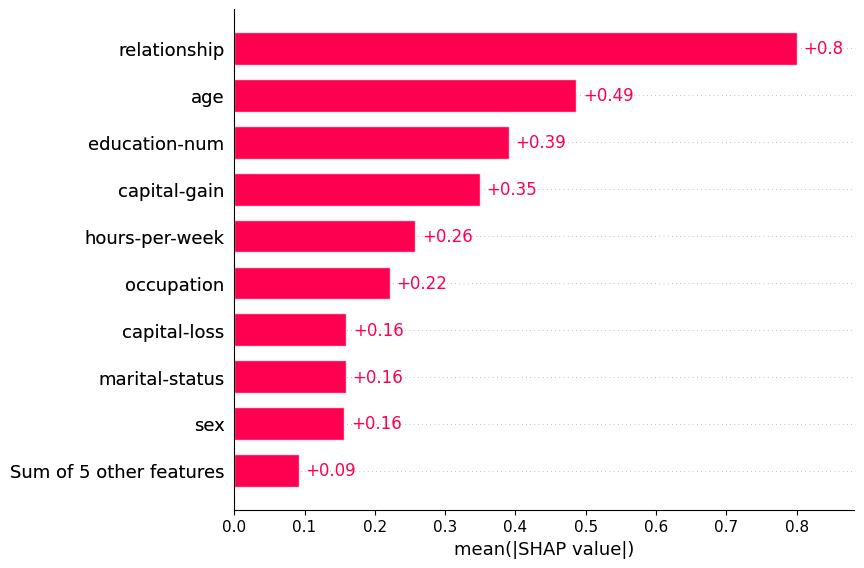

In [16]:
# Global importance for "age".
print(np.mean(np.abs(shap_values.values[:,0])))
# Bar plot showing global importance of all features.
shap.plots.bar(shap_values);

These scores can also be thought of similar to feature_importances in sklearn. However, as the following scores show, there are important differences.

**Question:** What might be the explanation of this difference and which one is better?


In [20]:
#importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_dict = dict(zip(gb_model.feature_names_in_, gb_model.feature_importances_))
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Sort the dataframe in decreasing order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
7,relationship,0.350066
10,capital-gain,0.222293
4,education-num,0.204569
0,age,0.062275
11,capital-loss,0.061563
12,hours-per-week,0.038240
5,marital-status,0.023957
6,occupation,0.022303
9,sex,0.005629
1,workclass,0.004237


### beeswarm Plot

This plot shows individual shap values of each feature, it also colors individual shap values with respect to the feature values. In this way, it is possible to see the relationship between feature values and the shapley values. Note that for categorical features care must be taken. If you label encode the categorical features than you should pay attention to which numbers correspond to which feature values. By default the feature values are numbered in sorted order in most packages. Another alternative is to one-hot encode the categorical features. The adult dataset in the shap package is label encoded.

In [16]:
X1, y1 = shap.datasets.adult()
X1

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


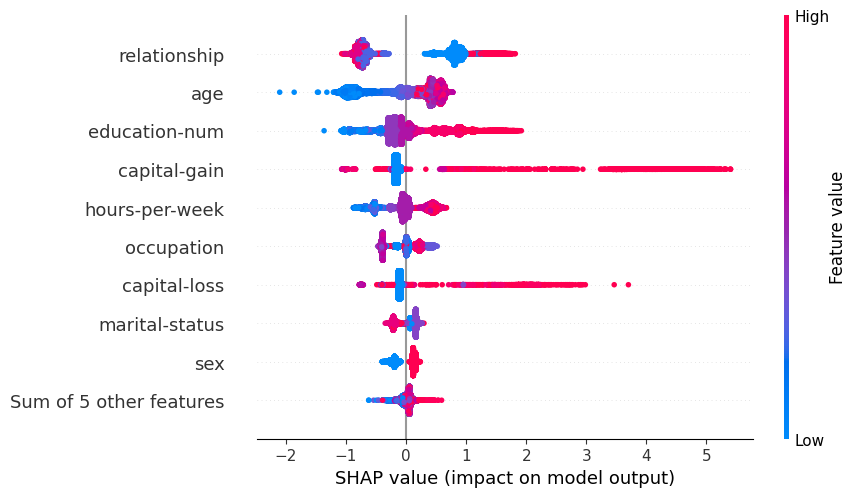

In [21]:
shap.plots.beeswarm(shap_values);

As can be seen in the above figure, the model tends to predict older people are more likely to have higher incomes, since the shap values of red points tend to have larger shap values. Note that in the dataset <50k and >50k is encoded as 0 and 1, respectively.

### Local Bar Plot

This plot shows the shap values for an individual sample.

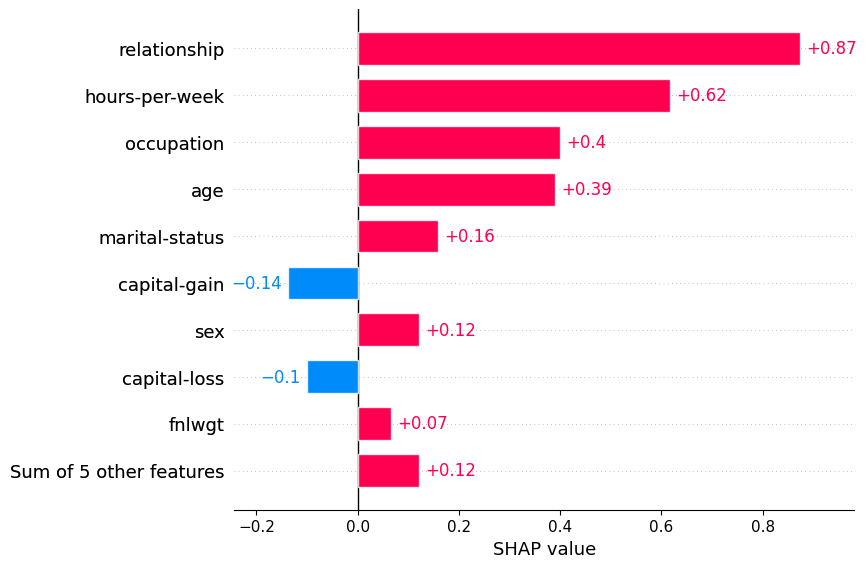

In [22]:
shap.plots.bar(shap_values[10]);

### Waterfall

In [25]:
avg = np.mean(shap_values.values)
print(avg)
print(np.log(avg/(1-avg)))

0.004260720715350995
-5.454047127552041


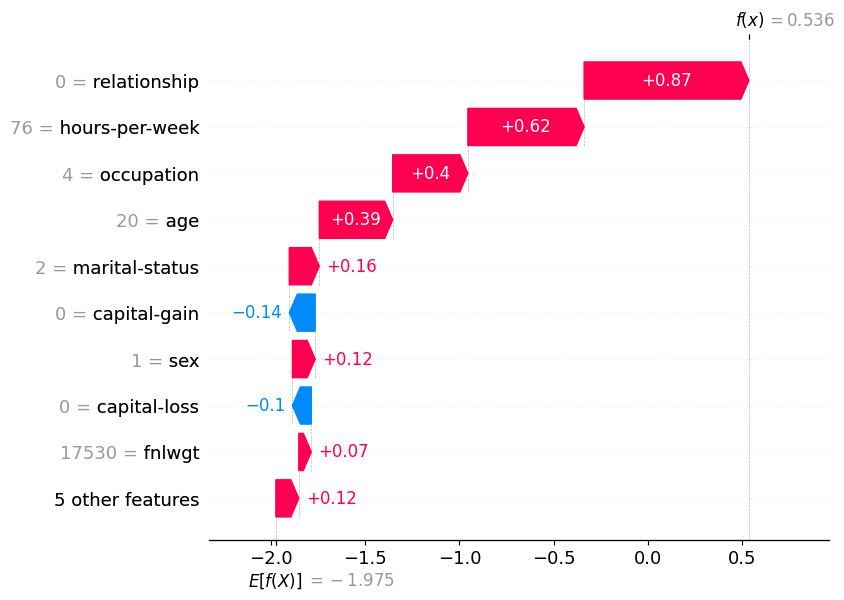

In [24]:
shap.plots.waterfall(shap_values[10])


In [19]:
shap.initjs()
shap.plots.force(shap_values[10])

### Cohort Bar Plot

cohorts() takes int or array. From the doc:
If this is an integer then we auto build that many cohorts using a decision tree. If this is an array then we treat that as an array of cohort names/ids for each instance.

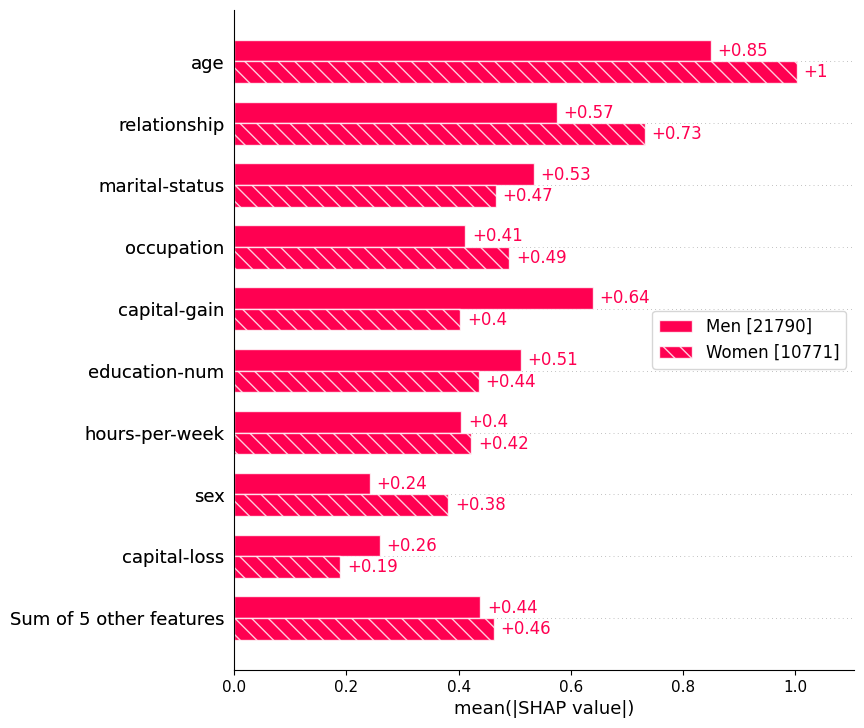

In [38]:
shap.plots.bar(shap_values.cohorts(sex))

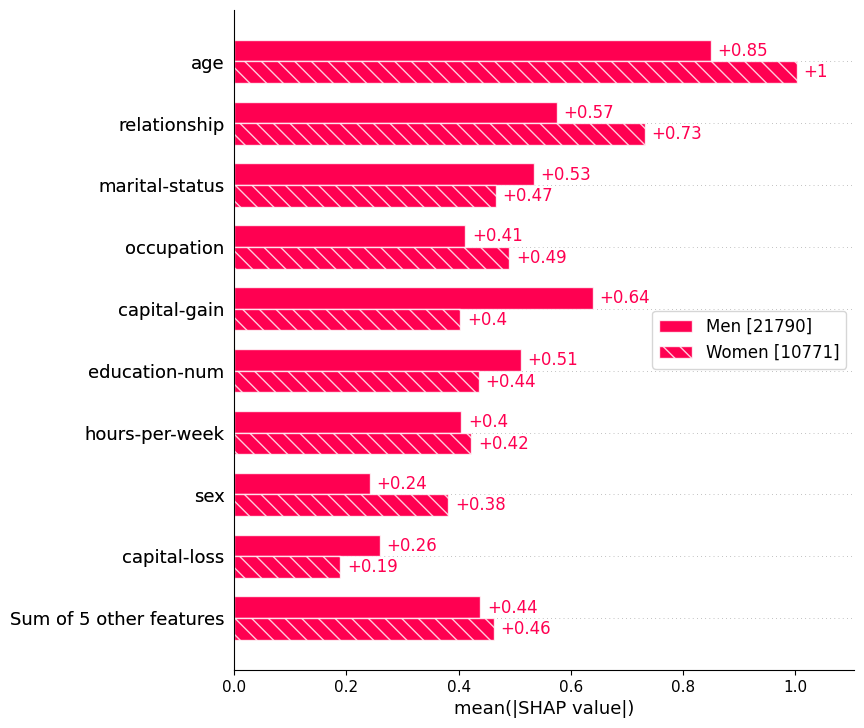

In [29]:
sex = ["Women" if shap_values[i,"sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

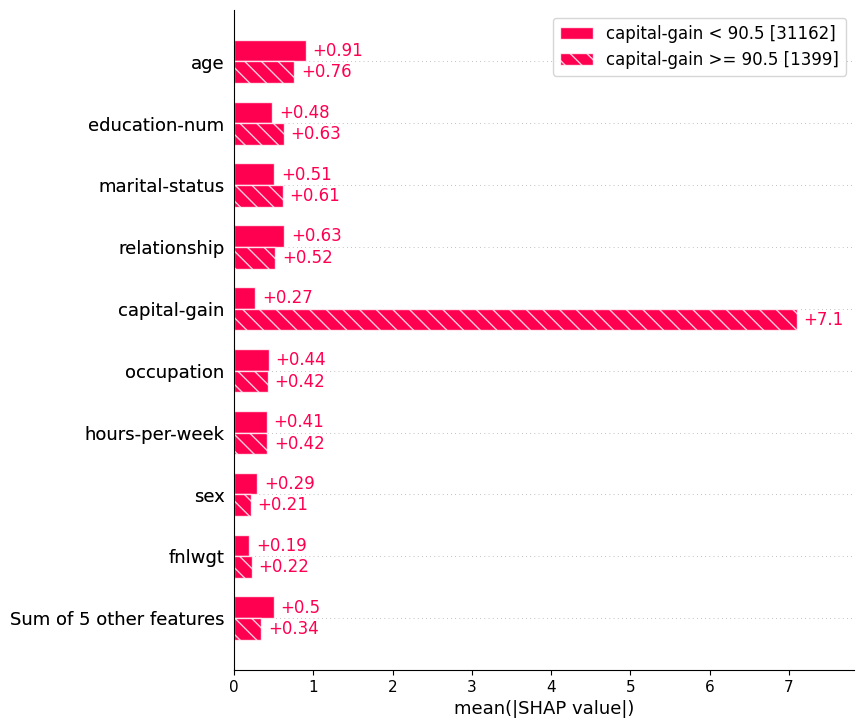

In [32]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))


In [31]:
np.unique(shap_values.base_values)

array([-2.66055214])

In [32]:
shap_values.base_values

array([-2.66055214, -2.66055214, -2.66055214, ..., -2.66055214,
       -2.66055214, -2.66055214])

In [31]:
shap.plots.force(shap_values[0:100])
